In [509]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt

# Parameters
gamma_m = 1.0              # measurement strength
Omega_0 = 0.1 * gamma_m    # Hamiltonian strength
sigma = 50                 # pulse width
top = 500 / gamma_m        # t_op the time of evolution
gamma = 1.25e-3 * gamma_m  # bit flip error rate
eta = 1                    # quantum efficiency (1 for ideal detectors)
tau = 2.5 / gamma_m        # measurement time parameter
dt = 0.1  # time step

# Thresholds
theta1 = -0.54
theta2 = 0.8


tlist = np.arange(0, top, dt)

# Filtering constant
alpha = dt / tau

# Pauli matrices and identity
I, X, Z = qeye(2), sigmax(), sigmaz()

omega_t = lambda t: Omega_0 * np.exp(-0.5 * ((t - top / 2) / sigma) ** 2)
delta_t = lambda t: Omega_0 * (t / (top / 2) - 1)

def op_on_qubit(op, i, N=3):
    return tensor([op if k == i else I for k in range(N)])

# Pauli operators on 3 qubits
X1, X2, X3 = [op_on_qubit(X, i) for i in range(3)]
Z1, Z2, Z3 = [op_on_qubit(Z, i) for i in range(3)]

# Stabilizers
S1 = Z1 * Z2
S2 = Z2 * Z3

# Collapse operators (bit-flip noise)
c_ops = [np.sqrt(gamma) * i for i in [X1, X2, X3]]

# Initial state: logical |0_L> = |000>
psi0 = tensor(basis(2,0), basis(2,0), basis(2,0))
rho = ket2dm(psi0)

# Target logical states for fidelity
zero = tensor(basis(2,0), basis(2,0), basis(2,0))
one  = tensor(basis(2,1), basis(2,1), basis(2,1))

# Initialize filtered stabilizer signals
I1_bar, I2_bar = 0.0, 0.0

# Record fidelity
fidelities_0 = []
fidelities_1 = []
fidelities_0_L = []
fidelities_1_L = []
errors = []


I1s = []
I2s = []

# Time evolution loop
for t in tlist:
    # Hamiltonian
    
    # a = 1 - t/top
    # b = t/top
    # H = -Omega_0 * (a * X1 * X2 * X3 + b * (Z1 + Z2 + Z3)/3)
            
    H = (X1 * X2 * X3)*omega_t(t) + ((Z1 + Z2 + Z3)/3)*delta_t(t)

    # Effective SME step
    dW1, dW2 = np.random.normal(scale=np.sqrt(dt), size=2)

    meas1 = np.sqrt(2 * gamma_m * eta) * (S1 * rho + rho * S1 - 2 * expect(S1, rho) * rho)
    meas2 = np.sqrt(2 * gamma_m * eta) * (S2 * rho + rho * S2 - 2 * expect(S2, rho) * rho)

    drho = -1j * (H * rho - rho * H)
    for c in c_ops:
        drho += c * rho * c.dag() - 0.5 * (c.dag() * c * rho + rho * c.dag() * c)
        
    drho += gamma_m * (S1 * rho * S1 - 0.5 * (S1**2 * rho + rho * S1**2))
    drho += gamma_m * (S2 * rho * S2 - 0.5 * (S2**2 * rho + rho * S2**2))
    
    drho += meas1 * dW1 + meas2 * dW2

    rho = (rho + dt * drho).unit()

    # Measurement currents (with noise)
    I1 = expect(S1, rho) + dW1 / np.sqrt(dt)
    I2 = expect(S2, rho) + dW2 / np.sqrt(dt)
    
    # Exponential filtering
    I1_bar = (1 - alpha) * I1_bar + alpha * I1
    I2_bar = (1 - alpha) * I2_bar + alpha * I2

    I1s.append(I1_bar)
    I2s.append(I2_bar)
    
    # Double threshold logic
    if I1_bar < theta1 and I2_bar > theta2:
        rho = X1 * rho * X1
        I1_bar, I2_bar = 1, 1
        errors.append(("X1", t))
    elif I1_bar < theta1 and I2_bar < theta1:
        rho = X2 * rho * X2
        I1_bar, I2_bar = 1, 1
        errors.append(("X2", t))
    elif I1_bar > theta2 and I2_bar < theta1:
        rho = X3 * rho * X3
        I1_bar, I2_bar = 1, 1
        errors.append(("X3", t))

    # Project to logical space and compute fidelity
    # theta = np.arctan2(b, a)
    # psi_target = (np.cos(theta / 2) * basis(2, 0) + np.sin(theta / 2) * basis(2, 1)).unit()
    # psi_target = (np.cos(theta / 2) * zero + np.sin(theta / 2) * one).unit()
    # rho_L_00 = zero.dag() * rho * zero
    # rho_L_01 = zero.dag() * rho * one
    # rho_L_10 = one.dag() * rho * zero
    # rho_L_11 = one.dag() * rho * one
    # rho_L = Qobj([[rho_L_00, rho_L_01], [rho_L_10, rho_L_11]], dims=[[2], [2]])
    
    # fidelities.append((psi_target.dag() * rho * psi_target))
    fidelities_0.append((zero.dag() * rho * zero))
    fidelities_1.append((one.dag() * rho * one))
    
print(errors)

[('X2', np.float64(302.40000000000003))]


In [510]:
# Initial state: logical |0_L> = |000>
rho = ket2dm(psi0)

# Record fidelity
fidelities_0_no_meas = []
fidelities_1_no_meas = []

# Time evolution loop
for t in tlist:
    H = (X1 * X2 * X3)*omega_t(t) + ((Z1 + Z2 + Z3)/3)*delta_t(t)

    drho = -1j * (H * rho - rho * H)
    for c in c_ops:
        drho += c * rho * c.dag() - 0.5 * (c.dag() * c * rho + rho * c.dag() * c)
    
    rho = (rho + dt * drho).unit()

    fidelities_0_no_meas.append((zero.dag() * rho * zero))
    fidelities_1_no_meas.append((one.dag() * rho * one))

[('X2', np.float64(302.40000000000003))]


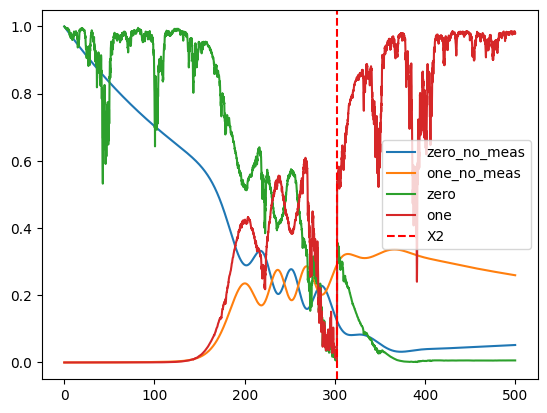

In [511]:
# Plot infidelity
# infidelities = [1 - f for f in fidelities_0]
print(errors)
plt.plot(tlist, fidelities_0_no_meas, label='zero_no_meas')
plt.plot(tlist, fidelities_1_no_meas, label='one_no_meas')
plt.plot(tlist, fidelities_0, label='zero')
plt.plot(tlist, fidelities_1, label='one')
for e in errors:
    plt.axvline(x=e[1], color='red', linestyle='--', label=e[0])  # Add this line
plt.legend()

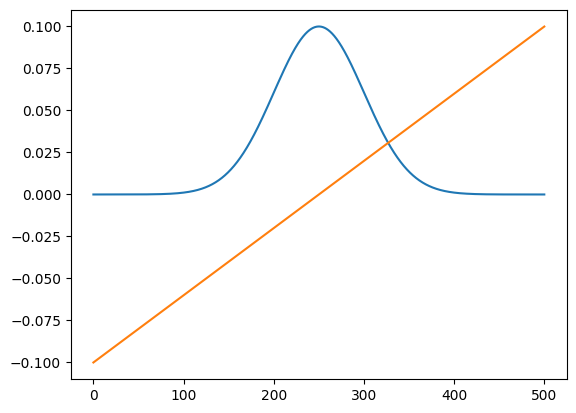

In [513]:
plt.plot(tlist, omega_t(tlist))
plt.plot(tlist, delta_t(tlist))
plt.show()

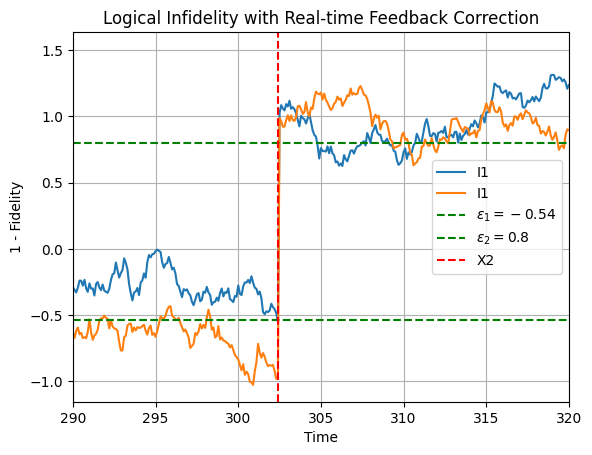

In [520]:
plt.plot(tlist, I1s, label='I1')
plt.plot(tlist, I2s, label='I1')
plt.axhline(theta1, color='green', linestyle='--', label=r'$\epsilon_1 = -0.54$')
plt.axhline(theta2, color='green', linestyle='--', label=r'$\epsilon_2 = 0.8$')
for e in errors:
    plt.axvline(x=e[1], color='red', linestyle='--', label=e[0])  # Add this line
    
# plt.yscale('log')
plt.xlim([290, 320])
plt.xlabel('Time')
plt.ylabel('1 - Fidelity')
plt.title('Logical Infidelity with Real-time Feedback Correction')
plt.grid(True)
plt.legend()
plt.show()